#### Parse dataset into doctor-only and patient-only text
- Laura's `parseconvos.py`

In [80]:
import pandas as pd
import re
import json




def load_data(dataset_file):
    # Load the JSONL file into a DataFrame
    data = []
    if dataset_file.endswith('.jsonl'):
        with open(dataset_file, "r") as file:
            for line in file:
                data.append(json.loads(line))
        df = pd.DataFrame(data)
    elif dataset_file.endswith('.csv'):
            df = pd.read_csv(dataset_file)
    else:
        raise ValueError("Unsupported file format. Please use .jsonl or .csv.")
    return df

# Define functions to extract dialogues
def extract_doctor_dialogue(text):
    if 'aci' in dataset_file:
        matches = re.findall(r"\[doctor\](.*?)(?=\[patient\]|\Z)", text, re.DOTALL)
       
    elif 'MTS' in dataset_file:
        matches = re.findall(r"Doctor:\s*(.*?)(?=Patient:|\Z)", text, re.DOTALL)

    return ' '.join(matches).strip() if matches else None

def extract_patient_dialogue(text):
    if 'aci' in dataset_file:
        matches = re.findall(r"\[patient\](.*?)(?=\[doctor\]|\Z)", text, re.DOTALL)
    elif 'MTS' in dataset_file:
        matches = re.findall(r"Patient:\s*(.*?)(?=Doctor:|\Z)", text, re.DOTALL)  
    return ' '.join(matches).strip() if matches else None

# Specify input file here
# dataset_file = "data/mts-dialog/MTS_Dataset_TrainingSet.csv"
dataset_file = "data/aci_combined.jsonl"
df = load_data(dataset_file)

# Apply the functions to extract dialogues and add as new columns
df['doctor_dialogue'] = df['dialogue'].apply(extract_doctor_dialogue)
df['patient_dialogue'] = df['dialogue'].apply(extract_patient_dialogue)


#### Apply NLTK VADER module to the dialogue
Outputs:
- neg
- neu
- pos
- compound


Note: must run `nltk.downloader.download('vader_lexicon')` first

In [81]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


# nltk.download('vader_lexicon')
def run_nltk_vader(text):
    if text:    
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(text)  # Use 'text' here instead of 'sentence'
        return ss['neg'], ss['neu'], ss['pos'], ss['compound']
    else:
        return 0.0, 0.0, 0.0, 0.0

# Apply the function and unpack results into separate columns
df[['doctor_dialogue_neg', 'doctor_dialogue_neu', 'doctor_dialogue_pos', 'doctor_dialogue_compound']] = df['doctor_dialogue'].apply(lambda x: pd.Series(run_nltk_vader(x)))
df[['patient_dialogue_neg', 'patient_dialogue_neu', 'patient_dialogue_pos', 'patient_dialogue_compound']] = df['patient_dialogue'].apply(lambda x: pd.Series(run_nltk_vader(x)))

# Calculate difference scores between doctor and patient
df['neg_diff'] = df['doctor_dialogue_neg'] - df['patient_dialogue_neg']
df['neu_diff'] = df['doctor_dialogue_neu'] - df['patient_dialogue_neu']
df['pos_diff'] = df['doctor_dialogue_pos'] - df['patient_dialogue_pos']
df['compound_diff'] = df['doctor_dialogue_compound'] - df['patient_dialogue_compound']
print(df['compound_diff'].describe())

# Save df with scores to CSV
df.to_csv('sentiment_output/aci_train_sentiment.csv', index=False)

count    87.000000
mean      0.249530
std       0.760129
min      -1.904600
25%       0.000850
50%       0.010900
75%       0.176050
max       1.979100
Name: compound_diff, dtype: float64


In [83]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer


nltk.download('vader_lexicon')
def run_nltk_vader(text):
    if text:    
        sid = SentimentIntensityAnalyzer()
        ss = sid.polarity_scores(text)  # Use 'text' here instead of 'sentence'
        return ss['neg'], ss['neu'], ss['pos'], ss['compound']
    else:
        return 0.0, 0.0, 0.0, 0.0

# Apply the function and unpack results into separate columns
df[['doctor_dialogue_neg', 'doctor_dialogue_neu', 'doctor_dialogue_pos', 'doctor_dialogue_compound']] = df['doctor_dialogue'].apply(lambda x: pd.Series(run_nltk_vader(x)))
df[['patient_dialogue_neg', 'patient_dialogue_neu', 'patient_dialogue_pos', 'patient_dialogue_compound']] = df['patient_dialogue'].apply(lambda x: pd.Series(run_nltk_vader(x)))

# Calculate difference scores between doctor and patient
df['neg_diff'] = df['doctor_dialogue_neg'] - df['patient_dialogue_neg']
df['neu_diff'] = df['doctor_dialogue_neu'] - df['patient_dialogue_neu']
df['pos_diff'] = df['doctor_dialogue_pos'] - df['patient_dialogue_pos']
df['compound_diff'] = df['doctor_dialogue_compound'] - df['patient_dialogue_compound']

# Save df with scores to CSV
df.to_csv('sentiment_output/aci_combined_sentiment.csv', index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/laurachen/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#### Analyzing differences in the `compound` scores
1. Descriptive stats
- Doctor - mean: 0.923, SD: 0.324
- Patient - mean: 0.662, SD: 0.654
2. Paired t-test
- t(66)=2.843
- p=0.006
- Statistically significant
3. Effect size
- Cohen's d for compound sentiment: 0.507
- Moderate effect size
4. Figure
- See below

In [84]:
# 1. Descriptive stats
## Doctor - mean: 0.923, SD: 0.324
## Patient - mean: 0.662, SD: 0.654

for sentiment in ['neg', 'neu', 'pos', 'compound']:
    doctor_stats = df[f'doctor_dialogue_{sentiment}'].describe()
    patient_stats = df[f'patient_dialogue_{sentiment}'].describe()
    print(f"Doctor {sentiment} Sentiment Descriptive Statistics:\n", doctor_stats)
    print(f"\nPatient {sentiment} Sentiment Descriptive Statistics:\n", patient_stats)

Doctor neg Sentiment Descriptive Statistics:
 count    87.000000
mean      0.066586
std       0.024917
min       0.024000
25%       0.049000
50%       0.066000
75%       0.080500
max       0.158000
Name: doctor_dialogue_neg, dtype: float64

Patient neg Sentiment Descriptive Statistics:
 count    87.000000
mean      0.104908
std       0.051395
min       0.000000
25%       0.071000
50%       0.099000
75%       0.130500
max       0.251000
Name: patient_dialogue_neg, dtype: float64
Doctor neu Sentiment Descriptive Statistics:
 count    87.000000
mean      0.778241
std       0.049764
min       0.634000
25%       0.751500
50%       0.787000
75%       0.809500
max       0.884000
Name: doctor_dialogue_neu, dtype: float64

Patient neu Sentiment Descriptive Statistics:
 count    87.000000
mean      0.700046
std       0.098922
min       0.000000
25%       0.662000
50%       0.705000
75%       0.751000
max       0.867000
Name: patient_dialogue_neu, dtype: float64
Doctor pos Sentiment Descriptive S

In [86]:
from scipy import stats

for sentiment in ['neg', 'neu', 'pos', 'compound']:
    stat, p_value = stats.ttest_rel(df[f'doctor_dialogue_{sentiment}'], df[f'patient_dialogue_{sentiment}'])
    print(f"Paired t-test for {sentiment} sentiment: t-statistic={stat:.3f}, p-value={p_value:.3f}")


Paired t-test for neg sentiment: t-statistic=-6.924, p-value=0.000
Paired t-test for neu sentiment: t-statistic=6.299, p-value=0.000
Paired t-test for pos sentiment: t-statistic=-3.492, p-value=0.001
Paired t-test for compound sentiment: t-statistic=3.062, p-value=0.003


In [87]:
for sentiment in ['neg', 'neu', 'pos', 'compound']:
    doctor_mean = df[f'doctor_dialogue_{sentiment}'].mean()
    patient_mean = df[f'patient_dialogue_{sentiment}'].mean()
    pooled_std = ((df[f'doctor_dialogue_{sentiment}'].std() ** 2 + df[f'patient_dialogue_{sentiment}'].std() ** 2) / 2) ** 0.5
    cohen_d = (doctor_mean - patient_mean) / pooled_std
    print(f"Cohen's d for {sentiment} sentiment: {cohen_d:.3f}")

Cohen's d for neg sentiment: -0.949
Cohen's d for neu sentiment: 0.999
Cohen's d for pos sentiment: -0.559
Cohen's d for compound sentiment: 0.445


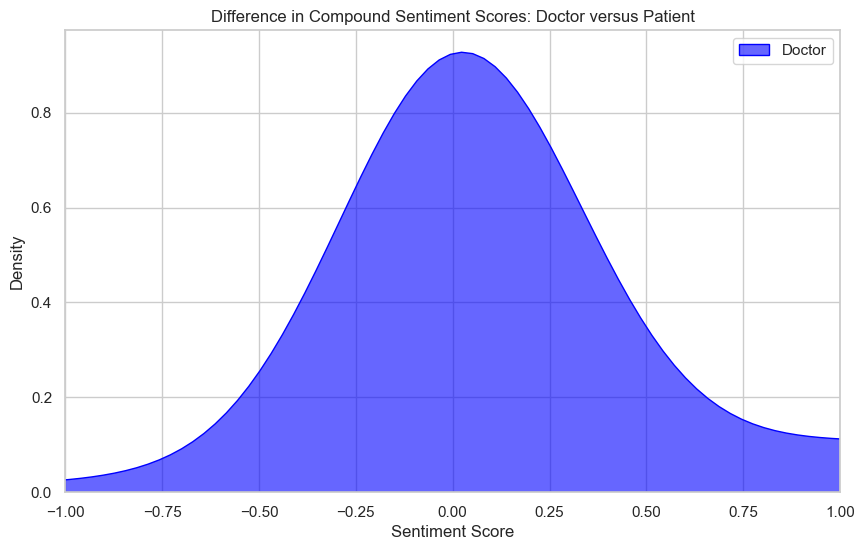

In [90]:
# Negative difference
sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.kdeplot(df['compound_diff'], fill=True, color='blue', label='Doctor', alpha=0.6)
# sns.kdeplot(df['patient_dialogue_compound'], fill=True, color='green', label='Patient', alpha=0.6)

# Adding titles, labels, and setting x-axis limits
plt.title('Difference in Compound Sentiment Scores: Doctor versus Patient')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.xlim(-1, 1)  # Set x-axis limits to match the range of compound sentiment scores
plt.legend()

plt.show()

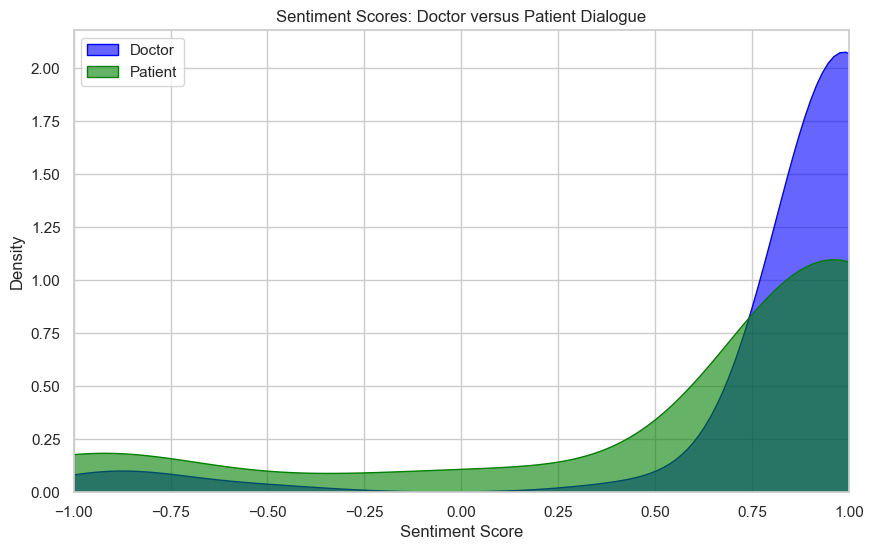

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.kdeplot(df['doctor_dialogue_compound'], fill=True, color='blue', label='Doctor', alpha=0.6)
sns.kdeplot(df['patient_dialogue_compound'], fill=True, color='green', label='Patient', alpha=0.6)

# Adding titles, labels, and setting x-axis limits
plt.title('Sentiment Scores: Doctor versus Patient Dialogue')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.xlim(-1, 1)  # Set x-axis limits to match the range of compound sentiment scores
plt.legend()

plt.show()